## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import binomial, choice
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm # for zscore(or ztest) and logistic regression
import scipy.stats as ss # for tscore(or ttest)
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df_ab_data = pd.read_csv('ab_data.csv')
df_ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df_ab_data.duplicated().sum()

0

b. Use the below cell to find the number of rows in the dataset.

In [4]:
len(df_ab_data)

294478

c. The number of unique users in the dataset.

In [5]:
df_ab_data.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
#proportion converted = Unique count of users who converted/ unique count of users in dataset
prop_converted = df_ab_data.query('converted == 1').user_id.count()/df_ab_data.user_id.count()

In [7]:
prop_converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

We Have 4 cases:<br>
group : Control (c)  and landing_page = old_page (oldP) <br>
group : Control (c)  and landing_page = new_page (newp) <br>
group : treatment (t)  and landing_page = old_page (oldp) <br>
group : treatment (t)  and landing_page = new_page (newp) <br>
**Note: these are the symbols we will use while declaring and inializing variables.**

In [8]:
df_c_oldp = df_ab_data.query('group == "control" and landing_page == "old_page"')
df_c_newp = df_ab_data.query('group == "control" and landing_page == "new_page"')
df_t_oldp = df_ab_data.query('group == "treatment" and landing_page == "old_page"')
df_t_newp = df_ab_data.query('group == "treatment" and landing_page == "new_page"')

In [9]:
print('Count of users in control group and trying old page is {} '.format(df_c_oldp.shape[0]))
print('Count of users in control group and trying new page is {} '.format(df_c_newp.shape[0]))
print('Count of users in treatment group and trying old page is {} '.format(df_t_oldp.shape[0]))
print('Count of users in treatment group and trying new page is {} '.format(df_t_newp.shape[0]))

Count of users in control group and trying old page is 145274 
Count of users in control group and trying new page is 1928 
Count of users in treatment group and trying old page is 1965 
Count of users in treatment group and trying new page is 145311 


f. Do any of the rows have missing values?

In [10]:
df_ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Based on the count of each column, we do not have any NAN values.

------------------------------

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
def drop_rows_by_query(copy_dataframe, f_query_statement=''):
    """
    Function: investigating in dataset brings us that we have non-aligned duplicate rows for the same user_id
    Variables: 
      copy_dataframe : dataframe  to modify
      f_query_statement: string; query statement to filter dataset with data to modify
      
    Drops rows in dataset ex : two rows one with same user id have new page under control and treatment. Since control group
    tests old page only and treatment group tests new page only. The non-aligned rows, where control not aligned with old
    page, and treatment not ligned with new page, must be dropped
   
    """
    if(f_query_statement.strip() != ''):
        df_view = copy_dataframe.query(f_query_statement)
    else:
        print('query is empty, please enter a defined query')
        return 
    #------- take index of rows to drop in list, then pass this list to pandas drop function
    li=df_view.index
    print('Rows count to drop {} '.format(len(li)))
    copy_dataframe.drop(li, axis=0, inplace=True)
    copy_dataframe.reset_index(drop=True, inplace=True)

In [12]:
# Take a copy of dataframe for rest of comming operations
df2 = df_ab_data.copy()

#### Define:
Drop rows where treatment is not aligned with new_page or control is not aligned with old_page.

We have two cases: <br>
1) rows with control | new_page. <br>
2) rows with treatment | old_page. <br>


#### Code:

**Drop non-aligned rows with control group and landing page of new_page.**

In [13]:
drop_rows_by_query(df2, 'group == "control" and landing_page == "new_page"')

Rows count to drop 1928 


**Drop non-aligned rows with treatment group and landing page of old_page.**

In [14]:
drop_rows_by_query(df2, 'group == "treatment" and landing_page == "old_page"')

Rows count to drop 1965 


#### Test:

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

**********************************************

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [16]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
df2[df2.user_id.duplicated(keep=False)].user_id

1876    773192
2862    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.shape

(290585, 5)

In [20]:
df2.drop(index=df2.index[1876], inplace=True)

In [21]:
df2.shape

(290584, 5)

************************************

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

$$P(converted)$$

In [22]:
p_convert = df2.query('converted == 1').user_id.count()/df2.shape[0]
p_convert

0.11959708724499628

$$P(\neg converted)$$

In [23]:
p_not_convert = 1 - p_convert
p_not_convert

0.8804029127550037

b. Given that an individual was in the `control` group, what is the probability they converted?

$$P(converted|control) = P(converted) * P(control|converted)$$

In [24]:
p_control_given_converted = df2.query('group == "control" & converted == 1').user_id.count()/df2.query('group == "control"').user_id.count()
p_control_given_converted

0.1203863045004612

In [25]:
p_converted_given_control = p_convert * p_control_given_converted
p_converted_given_control

0.014397851362444347

$$P(\neg converted|control) = P(\neg converted) * P(control|\neg converted)$$

In [26]:
p_control_given_not_converted = df2.query('group == "control" & converted == 0').user_id.count()/df2.query('group == "control"').user_id.count()
p_control_given_not_converted

0.8796136954995388

In [27]:
p_not_converted_given_control = p_not_convert * p_control_given_not_converted
p_not_converted_given_control

0.7744144596169868

$$P(control) = P(\neg converted|control) + P(converted|control)$$

In [28]:
p_control = p_not_converted_given_control + p_converted_given_control
p_control

0.7888123109794312

c. Given that an individual was in the `treatment` group, what is the probability they converted?

$$P(converted|treatment) = P(converted) * P(treatment|converted)$$

In [29]:
p_treatment_given_converted = df2.query('group == "treatment" & converted == 1').user_id.count()/df2.query('group == "treatment"').user_id.count()
p_treatment_given_converted

0.11880806551510564

In [30]:
p_converted_given_treatment = p_convert * p_treatment_given_converted
p_converted_given_treatment

0.014209098576819323

$$P(\neg converted|treatment) = P(\neg converted) * P(treatment|\neg converted)$$

In [31]:
p_treatment_given_not_converted = df2.query('group == "treatment" & converted == 0').user_id.count()/df2.query('group == "treatment"').user_id.count()
p_treatment_given_not_converted

0.8811919344848944

In [32]:
p_not_converted_given_treatment = p_not_convert * p_treatment_given_not_converted
p_not_converted_given_treatment

0.7758039458167174

$$P(treatment) = P(\neg converted|treatment) + P(converted|treatment)$$

In [33]:
p_treatment = p_not_converted_given_treatment + p_converted_given_treatment
p_treatment

0.7900130443935367

**Final Results: **<br>
$$P(converted|control) = P(converted|control) \div P(control)$$
$$P(converted|treatment) = P(converted|treatment) \div P(treatment)$$

In [34]:
p_converted_given_control = p_converted_given_control / p_control
p_converted_given_control

0.018252569289349974

In [35]:
p_converted_given_treatment = p_converted_given_treatment / p_treatment
p_converted_given_treatment

0.017985903748876847

d. What is the probability that an individual received the new page?

In [36]:
# Assuming we are getting the probability of independent event
p_new_page = df2.query('landing_page == "new_page"').user_id.count()/df2.user_id.count()
p_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

No, There is no sufficient evidence that we can convert to new page with great trust. By going through the data using Bayes rule of conditional probability, we get very close and insignificant results. We cannot use these results to estimate populations' view of both pages. If we look at probability of people converting from control group, we get a probability of 0.01825; while the probability of people converting from treatment group is 0.01799 ~ 0.018. So, the results show equal probability, which triggers the importance of testing more different samples to get better and precise results. From the sample given, we deduce sticking with the old webpage until further recollection and computational testing.   

*******************************************************
*******************************************************

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$ H_{null}: P_{new} <= P_{old} $$
$$ H_{alt}: P_{new} > P_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [37]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

********************************

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [38]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

****************************************

c. What is $n_{new}$?

In [39]:
# the samples of users who took new page to try
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

***************************************

d. What is $n_{old}$?

In [40]:
# the samples of users who took old page to try
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

************************************

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [41]:
new_page_converted = choice([1,0], size=n_new, p=[p_new,1-p_new], replace=True)
new_page_converted.mean()

0.11943431284839309

*******************************************

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [42]:
old_page_converted = choice([1,0], size=n_old, p=[p_old,1-p_old], replace=True)
old_page_converted.mean()

0.1196291146385451

*******************************

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [43]:
diff_mean = new_page_converted.mean() - old_page_converted.mean()
diff_mean

-0.00019480179015200771

********************************

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [44]:
# Used binomial instead of choice to avoid expense of for loop, and make use of broadcasting in numpy which results in faster
# process
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs

array([-8.48651515e-04, -2.28751955e-05, -7.78957987e-05, ...,
       -1.35106156e-03, -9.79380872e-04,  9.47927940e-04])

****************************************

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

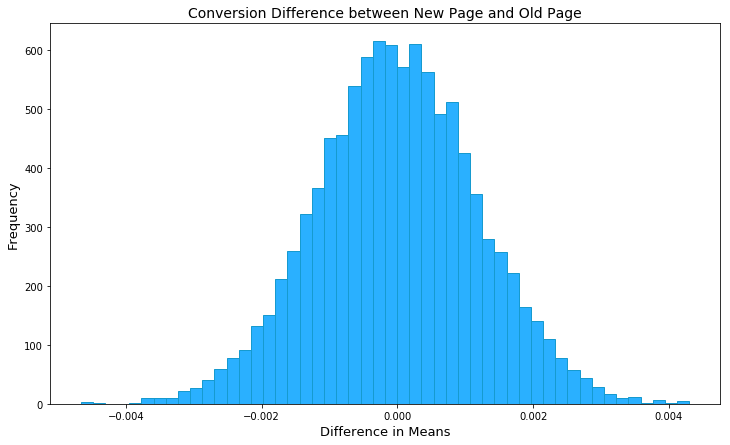

In [45]:
plt.figure(figsize=(12,7))
plt.hist(p_diffs, bins=50, facecolor = '#2ab0ff', edgecolor='#169acf')
plt.title('Conversion Difference between New Page and Old Page', fontsize=14)
plt.xlabel('Difference in Means', fontsize=13)
plt.ylabel('Frequency', fontsize=13);

********************************************************

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [46]:
act_diff= p_treatment_given_converted - p_control_given_converted
act_diff

-0.0015782389853555567

In [47]:
(p_diffs > act_diff).mean()

0.9105

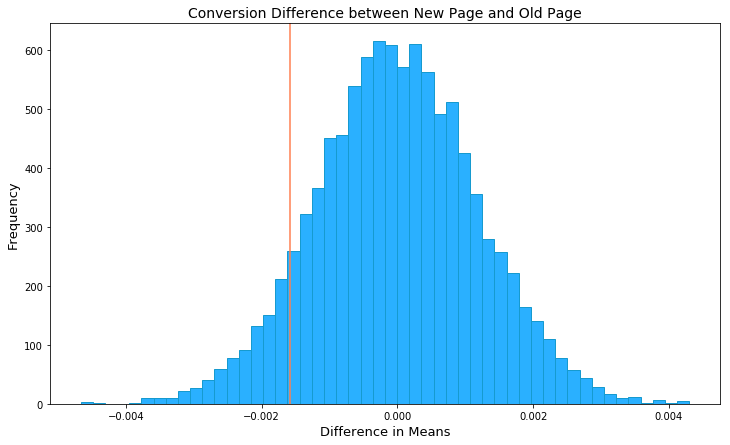

In [48]:
plt.figure(figsize=(12,7))
plt.hist(p_diffs, bins=50, facecolor = '#2ab0ff', edgecolor='#169acf')
plt.title('Conversion Difference between New Page and Old Page', fontsize=14)
plt.xlabel('Difference in Means', fontsize=13)
plt.ylabel('Frequency', fontsize=13);
plt.axvline(act_diff, color='#ff7f50');

*************************************************

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The computed value is the p-value that specifies if we reject null hypothesis or fail to reject null hypothesis. With p-value of $ \approx $ 0.9, we see that the new page did not get any better results, and so **we fail to reject the null hypothesis**. The rule is: Whenever we get p-value < $ \alpha $, we reject the null hypothesis and go for the alternative one, which is not the case in our results.

*****************************************

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [49]:
# do not forget to import: import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted
convert_new = df2.query('landing_page == "new_page"').converted

*****************************************

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [50]:
z_test, p_value = sm.stats.proportions_ztest([convert_old.sum(), convert_new.sum()], [n_old, n_new], alternative='smaller')
z_test, p_value

(1.3109241984234394, 0.9050583127590245)

************************************************************

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score shows a result less than the recommended test 1.645, that gives us a beginning indication that new page did not get us any better results. Beside, the p-value is $ \approx $ 0.90 > 0.05, so **we fail to reject the null hypothesis**. The results approximately match the step by step results taken above and yield same conclusion.
********************************

o. Use `scipy.stats_ttest` to compute your test statistic and p-value.

In [51]:
# the parameter alternative = 'greater', 'smaller', or 'two-sided' is added to scipy version 1.6.0
t_test, p_value = ss.ttest_ind(convert_old, convert_new, equal_var=False)
t_test, p_value

(1.310922637465592, 0.18988493791578323)

In [52]:
# result of one tailed test
1- (0.18988493791578323/2)

0.9050575310421084

The t-score shows a negative sign result less than the recommended test 1.645, that gives us a beginning indication that new page did not get us any better results. Beside, the p-value is $ \approx $ 0.19 > 0.05, so **we fail to reject the null hypothesis**. The results of t score approximately match the result of z score, but yield different p-value. Despite the difference in p-value, the two results (t_test, p_value) drive us to the same conclusion.

**************************************************
*************************************************

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

******************************************************************

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [53]:
df2['intercept'] = 1
conversion_dummy = pd.get_dummies(df2['landing_page'])
df2[['ab_page', 'old_page' ]]= conversion_dummy
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


*******************************************************

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [54]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
reg = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


*******************************************

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [55]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Jun 2021   Pseudo R-squ.:               8.077e-06
Time:                        11:40:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**************************************************

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**0.190**  <br>
The hypothesis for Logistic Regression are:<br>
$ H_{null}: p_{new} - p_{old} = 0 $ <br>
$ H_{alt}: p_{new} - p_{old} \neq 0 $ <br>
The logistic regression is not based on a random sample choice of 10000 turns as in AB test results. Moreover the AB test result got us a one side tailed test compared to $ \alpha $ = 0.05, whereas the logistic regression got us the result based on two sided test, which gives us more accurate result to base our decision on.

**********************************

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The general answer: if we are consider more factors that are related to our tests, we increase the chance of getting more accurate results and in return making better decision(s). In our case for example: it is good to have the feature added or updated in new_page, and check response variable of conversion against it. 
On the other hand, we should be very careful when adding explanatory or independent variables to our model. Some factors may alter the results and impact our decision in unuseful way, or these variables might be useless with no or little effect on our results, so no need to add them. [Multicolinearity](https://etav.github.io/python/vif_factor_python.html) is another factor to be careful with to avoid less reliable results. In summary, always add to the explanatory or independent variables the data that you made the test for and will really drive useful results.

****************************************************

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [56]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [57]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [58]:
### Create the necessary dummy variables
country_dummy = pd.get_dummies(df_new.country)
df_new[['CA', 'UK', 'US']] = country_dummy
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [59]:
log_mod =  sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
reg = log_mod.fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Jun 2021   Pseudo R-squ.:               1.521e-05
Time:                        11:41:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

It seems from the results provided that the country did not provide us any new result or prove any statististical significance to switch to new page from old page. Checking the confidence interval , log-likelihood with just two df models, shows us that the old page is yet the winning competitor in this test. 

**********************************************

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
df_new['ab_uk'] = df_new['ab_page'] * df_new['UK']
df_new['ab_us'] = df_new['ab_page'] * df_new['US']

In [61]:
log_mod =  sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'ab_uk', 'ab_us']])
reg = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [62]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Jun 2021   Pseudo R-squ.:               3.482e-05
Time:                        11:41:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_uk          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_us          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [63]:
# get params
np.exp(reg.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
US           1.017682
ab_uk        1.081428
ab_us        1.048001
dtype: float64

In [64]:
1 / np.exp(reg.params)

intercept    7.418713
ab_page      1.069775
UK           0.988285
US           0.982625
ab_uk        0.924703
ab_us        0.954198
dtype: float64

Although we tried a different approach to check the interaction between new_page and countries, none of the independent variables showed any statistical significance that encourage the acceptance of alternative hypothesis.

************************************************
************************************************

<a id='conclusions'></a>
## Conclusion

The three different methods proof the same result that we do not have enough evidence to move our design to the new page. Therefore, until collecting further samples or performing more tests, the current data shows we should stick to old page. 
<br> <br>
To improve our analysis, some of these suggestions might help: <br>
1) **increasing the sample size**: running the experiment on larger groups might increase the accurancy of results interpreted and help us drive better decisions. <br>
2) **Add important variables or columns**: Adding variable like feature added or updated might help us get better insight on what exactly the feature that we ran the test for and give look at results from different perspective. It is always preferred for accuracy of results to add or update one or two features at most in the page, so we can get exactly what would be eye-catching for the customer.<br>
3) **choose the technique or algorithm wisely**: It is preffered to get sometime looking at the data to specify what is the best technique or machine learning algorithm that would drive the best accurate results. This time allocated would never come at low cost, because not only you are getting results for current samples, but also assigning a technique used in other future collected samples <br>
4) **Using time to conclude more accurate results**: the time column is also a variable that could be used, for example: the numbers might be high or low due to days where people are at work, or in holidays. Also, in an ecommerce websites, the customers may not have interest in certain product(s), so we have low values, which is discovered too with time.

******************************************
******************************************

## References

[1] <br> https://www.analyticsvidhya.com/blog/2020/10/ab-testing-data-science/ <br>
[2]<br> https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce <br>
[3]<br> https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/ <br>
[4]<br> https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/ <br>
[5]<br> https://www.khanacademy.org/math/ap-statistics/tests-significance-ap/idea-significance-tests/v/p-values-and-significance-tests <br>
[6]<br> https://www.geeksforgeeks.org/how-to-get-weighted-random-choice-in-python/ <br>
[7]<br> https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html <br>
[8]<br> https://stackoverflow.com/questions/62046716/appending-to-numpy-array-within-a-loop <br>
[9]<br> https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca <br>
[10]<br> https://stackoverflow.com/questions/43025450/how-can-i-type-approximate-equal-sign-in-markdown-jupyter <br>
[11]<br> https://www.analyticsvidhya.com/blog/2020/10/ab-testing-data-science/ <br>
[12]<br> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html <br>
[13]<br> https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html <br>